# CS 135 day09: Evaluating Binary Classifiers

# Objectives

* See how evaluation metrics vary over possible decision thresholds
* Learn how to use sklearn utilities to compute ROC curves and confusion matrices
* Learn how to make plots to understand different loss functions


# Outline
* Setup: Binary classification on 1-dim. toy example
* Part 1: Confusion matrix at different thresholds
* Part 2: ROC curves and area under the curve
* Part 3: Zero one loss (aka error rate)
* Part 4: Log loss (aka cross entropy)
* Part 5 (Bonus): Visualizing decision boundaries of Logistic Regression on 2-dim. features
* Part 6 (Bonus): Visualizing decision boundaries of K-NN on 2-dim. features

# Takeaways

* Confusion matrices and their derived metrics (ACC, TPR, TNR, etc) require selecting a threshold
* * Default threshold in sklearn is 0.5
* * This default is not always the best one to pick depending on your application

* ROC curves allow us to visualize what the classifier can achieve across possible thresholds
* * Look at tradeoffs between TPR and FPR
* * Area under the ROC curve (abbreviated AUROC) is a single score often used to measure classifier quality
* * AUROC is not sensitive to the scale of the predicted probabilities, only their relative ranking

* Log loss (aka binary cross entropy) 
* * Can be used to directly assess quality of predicted probabilities (no threshold needed)
* * Justified as upper bound of error rate (zero one loss with threshold 0.5)
* * Might have some numerical issues -- log(0.0) -- that you want to avoid in practice

In [1]:
import numpy as np

In [2]:
import sklearn.linear_model
import sklearn.neighbors

In [3]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

<a id="setup"></a>

# Setting up a simple classification task with 1-dim features

Let's think about a classification task where:

Each input is just scalar $x$ between -1 and +1.

The "true" label assignment function is as follows:

$$
y(x) = \begin{cases} 
1 & \text{if} ~ x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

The true labeling process also has some noise: after assigning a label with the above function, each example has a ~15% chance of the opposite label. 

This noise makes our classification interesting. The "best case" error rate is about ~15%.

### Make training set for 1-dim. toy example

In [4]:
# We generated this training set for you.

N = 12

x_N = np.asarray([
    -0.975, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.976])
x_N1 = x_N.reshape((N,1)) # need an (N,1) shaped array for later use with sklearn

y_N = np.asarray([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

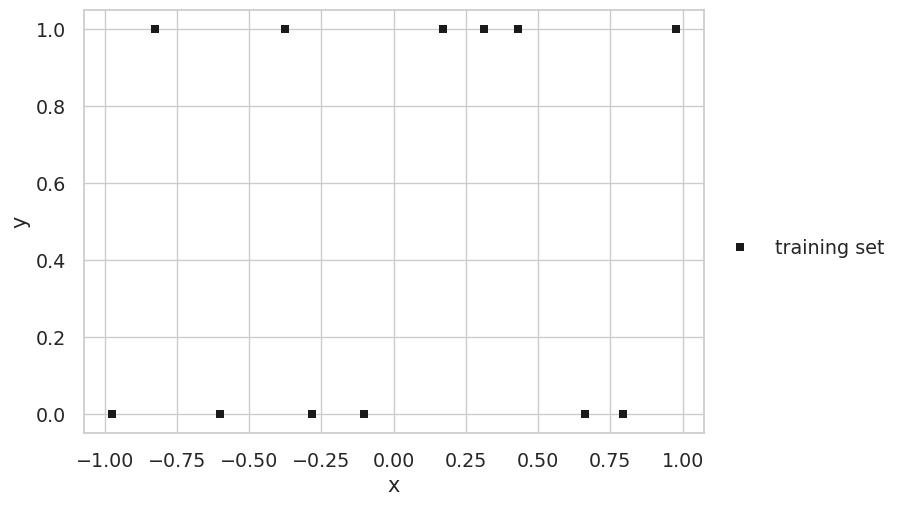

In [5]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

### Make validation set for 1-d toy example

In [6]:
def make_dataset(n_examples=10, seed=101, flip_fraction=0.15):
    N = int(n_examples)
    prng = np.random.RandomState(seed)

    # Make x values between -1 and 1, roughly evenly spaced
    x_N = np.linspace(-1, 1, N) + 0.05 * prng.randn(N)

    # Make y values such that broadly, the true function says:
    # y_n = 1  if x_n > 0 
    # y_n = 0  otherwise
    y_N = np.asarray(x_N > 0, dtype=np.int32)

    # flip a small percentage of the values
    chosen_ids = prng.permutation(np.arange(N))[:int(np.floor(flip_fraction * N))]
    y_N[chosen_ids] = 1 - y_N[chosen_ids]
    return x_N.reshape((N,1)), y_N

In [7]:
M = 100
x_va_M1, y_va_M = make_dataset(n_examples=M, seed=201)

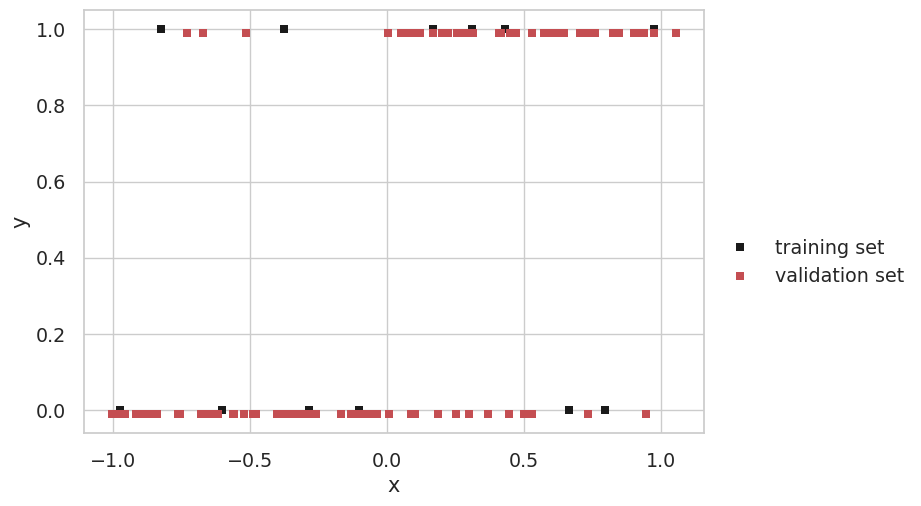

In [8]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.plot(x_va_M1, y_va_M - 0.01, 'rs', label='validation set'); # add small vertical offset so you can see

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

<a id="part1"></a>

# Setup: Train a logistic regression model for F=1 data

Here, we'll fit a Logistic Regression probabilistic classifier to the above 1-dim. feature dataset.

In [9]:
# We'll use C = 10000.0 for now. You could select it like any hyperparameter on validation data.

lr = sklearn.linear_model.LogisticRegression(C=10000.0, penalty='l2');

In [10]:
lr.fit(x_N1, y_N)

LogisticRegression(C=10000.0)

# Setup: Train a k-nearest neighbors model for F=1 data

Here, we'll fit a K Nearest probabilistic classifier to the above 1-dim. feature dataset.

In [11]:
# We'll use K = 3 neighbors for now. In a real task, could select it like any hyperparameter on validation data.

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [12]:
knn.fit(x_N1, y_N)

KNeighborsClassifier(n_neighbors=3)

# Setup: Plot predicted probabilities vs feature value

We'll again use the same dense grid of L inputs to understand the predicted probability function.

In [13]:
# Create dense grid of L input examples from -1.5 to 1.5
# so we can better understand the learned predictions
L = 101
dense_x_L1 = np.linspace(-1.5, 1.5, L).reshape((L,1))
yproba1_dense_L = lr.predict_proba(dense_x_L1)[:,1]

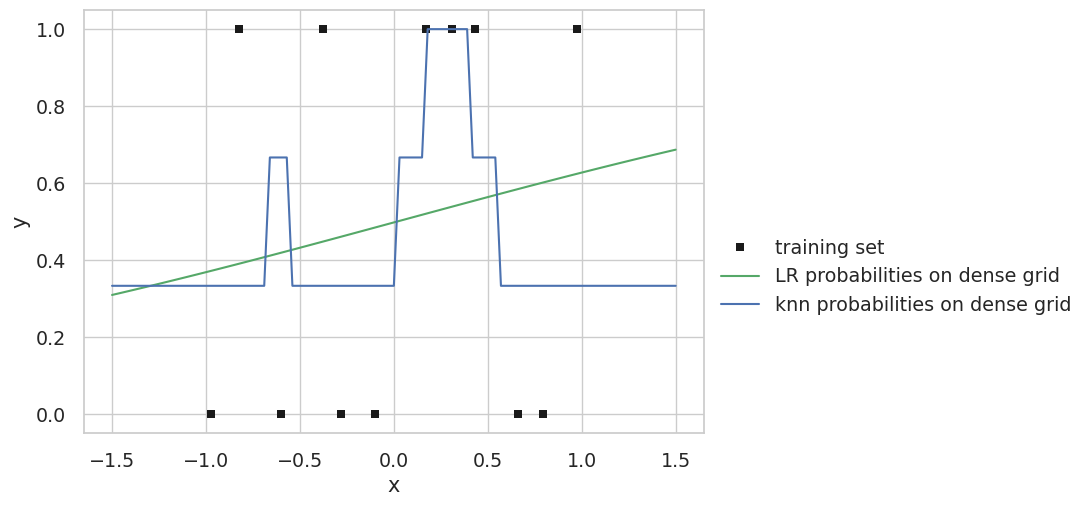

In [14]:
plt.plot(x_N, y_N, 'ks', label='training set');

plt.plot(dense_x_L1, lr.predict_proba(dense_x_L1)[:,1], 'g-', label='LR probabilities on dense grid')
plt.plot(dense_x_L1, knn.predict_proba(dense_x_L1)[:,1], 'b-', label='knn probabilities on dense grid')

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

<a id="part1"></a>

# Part 1: Computing confusion matrices on validation set

Remember, the order of the cells in a confusion matrix is like this diagram:

    | -- | -- |
    | TN | FP |
    | FN | TP |
    | -- | -- |

### Worked example: get LR classifier's predicted probabilities


In [15]:
lr_yproba1_va_M = lr.predict_proba(x_va_M1)[:,1]

print(lr_yproba1_va_M)

[0.3707299  0.36822562 0.38134371 0.37899167 0.37426657 0.3839977
 0.37954425 0.38352674 0.38430423 0.38670724 0.38875016 0.39940746
 0.41064286 0.39857401 0.40988818 0.40238207 0.4090979  0.42428832
 0.41249588 0.42461542 0.41690936 0.41538799 0.44553107 0.43042779
 0.43501943 0.42905724 0.43378698 0.43349065 0.44513897 0.45032524
 0.45299195 0.45541044 0.44933722 0.45831816 0.45857011 0.45842505
 0.46379018 0.46070838 0.46299112 0.46347596 0.48055986 0.48076035
 0.48154235 0.48531477 0.49328092 0.4893604  0.48748782 0.47588122
 0.49902081 0.492673   0.51132645 0.49857884 0.50462696 0.51226505
 0.51153703 0.50879417 0.51390828 0.50934366 0.52004805 0.52252955
 0.53555535 0.52437684 0.53099707 0.52719207 0.53178471 0.53727022
 0.53754212 0.55199498 0.54655297 0.55665779 0.55302556 0.53941597
 0.55705483 0.56752805 0.56738894 0.56009607 0.56377282 0.57814507
 0.57538802 0.5731248  0.57667294 0.57968162 0.58034917 0.58277062
 0.59385632 0.58271324 0.59030932 0.5937017  0.5901993  0.60843

### Exercise 1a: Now, get the K-NN classifier's predicted probabilities of positive class

In [16]:
knn_yproba1_va_M = np.zeros(M) # TODO call predict_proba on knn

### Exercise 1b: Compute LR confusion matrix at threshold of 0.5

In [17]:
print("LR confusion at threshold 0.5")
print(sklearn.metrics.confusion_matrix(y_va_M, lr_yproba1_va_M >= 0.5))

LR confusion at threshold 0.5
[[47 11]
 [ 4 38]]


### Exercise 1c: Compute LR confusion matrix across range of thresholds 0.1, .... 0.9

In [18]:
for thr in [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]:
    print("LR confusion at threshold %.3f" % thr)
    print(sklearn.metrics.confusion_matrix(y_va_M, lr_yproba1_va_M >= thr))

LR confusion at threshold 0.000
[[ 0 58]
 [ 0 42]]
LR confusion at threshold 0.200
[[ 0 58]
 [ 0 42]]
LR confusion at threshold 0.400
[[13 45]
 [ 0 42]]
LR confusion at threshold 0.500
[[47 11]
 [ 4 38]]
LR confusion at threshold 0.600
[[57  1]
 [33  9]]
LR confusion at threshold 0.800
[[58  0]
 [42  0]]
LR confusion at threshold 1.000
[[58  0]
 [42  0]]


### Exercise 1d: Which of the above thresholds gives the best *accuracy*?

In [19]:
# TODO compute the accuracy at each threshold given printed matrices above

### Exercise 1e: Which of the above thresholds gives the best *true positive rate*?

In [20]:
# TODO compute the TPR at each threshold given printed matrices above

<a id="part2"></a>

# Part 2: ROC curves

This is a brief demo of creating an ROC curve for comparing the LR and KNN classifiers from above.

In [37]:
lr_proba1_va_M = lr.predict_proba(x_va_M1)[:,1]
knn_proba1_va_M = knn.predict_proba(x_va_M1)[:,1]

In [38]:
lr_fpr, lr_tpr, lr_thresholds = sklearn.metrics.roc_curve(y_va_M, lr_proba1_va_M)
knn_fpr, knn_tpr, knn_thresholds = sklearn.metrics.roc_curve(y_va_M, knn_proba1_va_M)

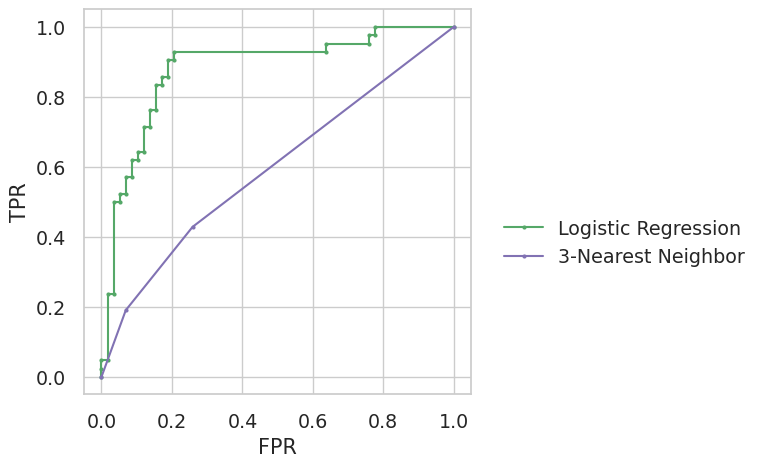

In [39]:
plt.figure(figsize=(5,5));
plt.plot(lr_fpr, lr_tpr, 'g.-', label='Logistic Regression');
plt.plot(knn_fpr, knn_tpr, 'm.-', label='3-Nearest Neighbor');

plt.xlabel('FPR');
plt.ylabel('TPR');
plt.legend(bbox_to_anchor=(1.75, 0.5));

### Discussion 2a: Is there any FPR value where the 3-NN classifier has better TPR than the LR classifier?

In [25]:
# TODO write your answer here, then discuss

### Exercise 2b: Visually, estimate the area under the 3-NN ROC curve above

In [26]:
# TODO write your answer here for the 3-NN curves, by manually interpreting the plot above.

### Exercise 2c: Use sklearn functions to compute 3-NN AUROC (area under roc curve)

Use the `roc_auc_score` function, with docs here:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html


In [27]:
sklearn.metrics.roc_auc_score(y_va_M, np.zeros(M)) # TODO replace "zeros" array with predicted probas from 3-NN

0.5

### Exercise 2d: Suppose you multiplied all probabilities by 0.5.... what happens to the AUROC?

In [28]:
sklearn.metrics.roc_auc_score(y_va_M, 0.5 * np.zeros(M)) # TODO replace "zeros" array with predicted probas from 3-NN

0.5

Punchline: AUROC scores are about *relative ranking*, and have little to do with the *absolute scale* of the predicted probabilities or scores

<a id="part3"></a>

# Part 3: Zero-one loss aka mean error rate

Given a predicted probability $p$, we can make a hard binary decision by *thresholding*

$$
\hat{y}(p, \tau) = \begin{cases}
1 & \text{if}~ p >= \tau
\\
0 & \text{otherwise}
\end{cases}
$$

Zero one loss as a function of predicted probability $p$

$$
\ell(p) = \begin{cases}
1 & \text{if}~ y == \hat{y}(p, \tau)
\\
0 & \text{otherwise}
\end{cases}
$$

The average zero-one loss across $N$ examples is the same as the *error rate*.

You can interpret this as fraction of mistakes.


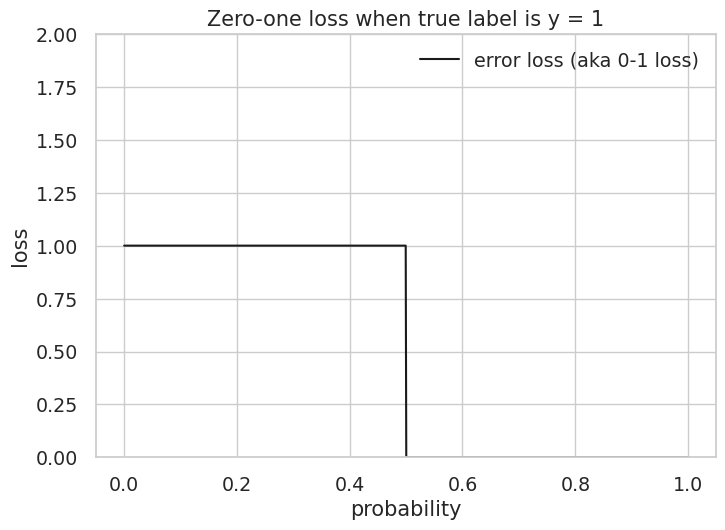

In [29]:
# Consider loss as a function of predicted probability

ytrue = 1
thr = 0.5 # decision threshold

eps = 0.001
p_grid = np.linspace(eps, 1.0 - eps, 1000)
ytrue_grid = ytrue * np.ones_like(p_grid)

zeroone_loss_grid = np.asarray(p_grid < thr, dtype=np.float64);

plt.plot(p_grid, zeroone_loss_grid, 'k-', label='error loss (aka 0-1 loss)');
plt.legend(loc='upper right');
plt.xlabel('probability');
plt.ylabel('loss');
plt.title('Zero-one loss when true label is y = 1')
plt.ylim([0, 2.0]);

### Exercise 3a: Repeat the above but make a plot for the case that true label is y = 0

In [30]:
# TODO copy above code here and modify appropriately

<a id="part4"></a>

# Part 4: Log loss aka binary cross entropy

The log loss for a single prediction with true label $y$ and predicted probility of positive class $p \in (0,1)$ is:
$$
\text{log\_loss}(y, p) = - y \log_2 p - (1-y) \log_2 (1 - p)
$$

The output of the log loss is a real number. It must be 0.0 or greater.

The larger this loss value, the *worse* the predicted probability is.

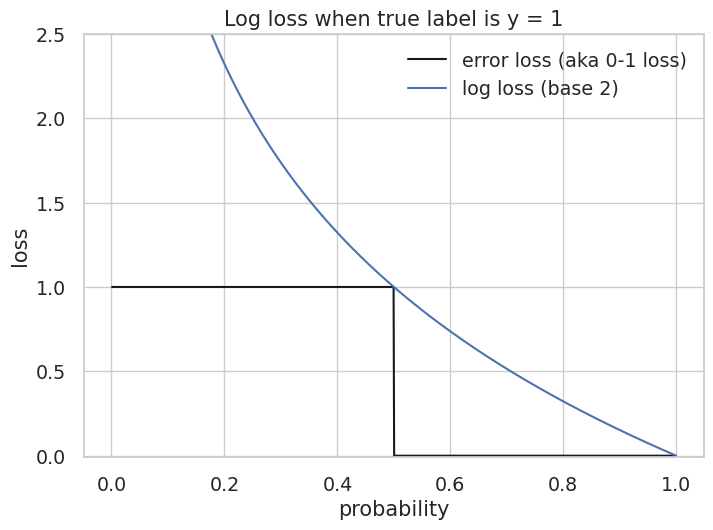

In [31]:
# Consider loss as a function of predicted probability

ytrue = 1
thr = 0.5 # decision threshold

eps = 0.001
p_grid = np.linspace(eps, 1.0 - eps, 1000)
ytrue_grid = ytrue * np.ones_like(p_grid)

zeroone_loss_grid = np.asarray(p_grid < 0.5, dtype=np.float64);
log_loss_grid = -1 * (ytrue_grid * np.log2(p_grid) + (1-ytrue_grid) * np.log2(1-p_grid));

plt.plot(p_grid, zeroone_loss_grid, 'k-', label='error loss (aka 0-1 loss)');
plt.plot(p_grid, log_loss_grid, 'b-', label='log loss (base 2)');
plt.legend(loc='upper right');
plt.xlabel('probability');
plt.ylabel('loss');
plt.title('Log loss when true label is y = 1')
plt.ylim([-.01, 2.5]);

### Exercise 4a: Repeat the above but make a plot for the case that true label is y = 0

In [41]:
# TODO copy above code here and modify appropriately


### Discussion 4b: What happens to log loss when the true label is 1 and predicted probability is exactly 1.0?

Recall the formula:

$$
\text{log\_loss}(y, p) = - y \log_2 p - (1-y) \log_2 (1 - p)
$$

What is the log loss at $y=1$ and $p=1$?
Is there any numerical trouble that you get into by evaluating the logarithm at this probability value?

In [33]:
# TODO write your answer

### Discussion 4c: What happens to log loss when the true label is 1 and predicted probability is exactly 0.0?

What is the log loss at $y=1$ and $p=0.0$ (exact zero)?

Is there any numerical trouble that you get into by evaluating the logarithm at this probability value?

In [34]:
# TODO write your answer

### Discussion 4d: How can we fix numerical issues with log(0)?

See above how we do not let $p$ go to 0.0 but instead say that the smallest probability $p$ allowed is a small positive value $\epsilon$

We assume here that $1.0 * \log(0.0)$ should be replaced by $\log(\epsilon)$ for small positive $\epsilon$

Why does this help?

# Setup for Parts 4 - 5

### Define simple dataset of points in 2D space

Don't worry about the details of this setup.
Just try to understand the plots below.

In [43]:
def create_2d_dataset(N=100, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    mA_2 = np.asarray([1, 0])
    covA_22 = np.square(noise_stddev) * np.eye(2)
    
    mB_2 = np.asarray([0, 0])
    covB_22 = np.square(noise_stddev) * np.eye(2)

    mC_2 = np.asarray([0, 1])
    covC_22 = np.square(noise_stddev) * np.eye(2)

    # Draw data from 3 "Gaussian" blobs
    xA_N2 = random_state.multivariate_normal(mA_2, covA_22, size=N)
    xB_N2 = random_state.multivariate_normal(mB_2, covB_22, size=N)
    xC_N2 = random_state.multivariate_normal(mC_2, covC_22, size=N)

    x_N2 = np.vstack([xA_N2, xB_N2, xC_N2])
    y_N = np.hstack([np.ones(xA_N2.shape[0]), np.zeros(xB_N2.shape[0]), np.ones(xC_N2.shape[0])])
    
    return x_N2, y_N

## Create the dataset with 100 points per class

In [50]:
x_N2, y_N = create_2d_dataset(N=100, noise_stddev=0.3)

## Define function to plot data as scatterpoints in 2d

In [51]:
def plot_pretty_data_colored_by_labels(x_N2, y_N):
    plt.plot(x_N2[y_N==0,0], x_N2[y_N==0,1], color='r', marker='x', linestyle='', markersize=5, mew=2, label='y=0');
    plt.plot(x_N2[y_N==1,0], x_N2[y_N==1,1], color='b', marker='+', linestyle='', markersize=8, mew=2, label='y=1');

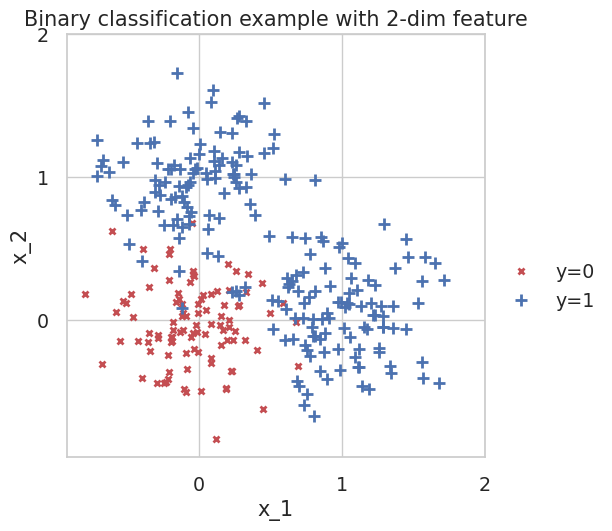

In [52]:
plot_pretty_data_colored_by_labels(x_N2, y_N);
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.xlabel('x_1');
plt.ylabel('x_2');
plt.gca().set_aspect(1.0);
plt.xticks([0, 1, 2]);
plt.yticks([0, 1, 2]);
plt.title("Binary classification example with 2-dim feature");

### Define function to make pretty plots of predicted probability color fields

You don't need to understand this in detail. Just a utility function.

In [53]:
def plot_pretty_probabilities_for_clf(
        clf,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yproba1_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

### Define function to visualize hard decisions made as threshold

You don't need to understand this in detail. Just a utility function you'll use below.

In [57]:
def plot_pretty_decision_boundaries_for_clf(
        clf,
        threshold=0.5,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    yhat_M = yproba1_M >= threshold
    
    # Reshape the M probas into the GxH 2D field
    yhat_GH = np.reshape(yhat_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yhat_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

# Part 5: Visualization of KNN predictions as we vary K

### Figure:  KNN predicted proba (colors) over 2D plane of x1, x2 

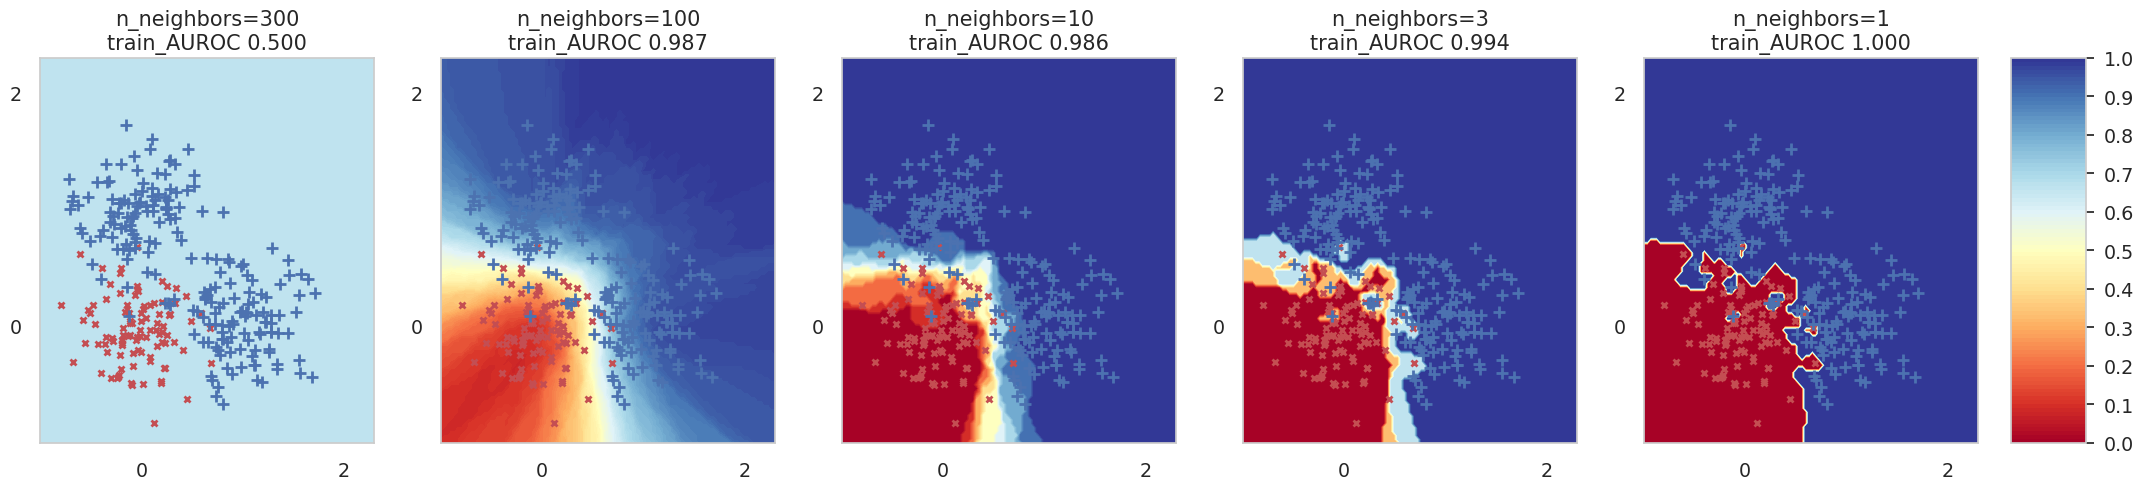

In [58]:
n_neighbors_grid = [y_N.size, 100, 10, 3,  1]
ncols = len(n_neighbors_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, n_neighbors in enumerate(n_neighbors_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='brute')
    clf.fit(x_N2, y_N)
    auroc = sklearn.metrics.roc_auc_score(y_N, clf.predict_proba(x_N2)[:,1])

    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("n_neighbors=%d\ntrain_AUROC %.3f" % (n_neighbors, auroc))

## KNN: hard binary decisions (colors) over 2D plane of (x1, x2)

Using Threshold: 0.5

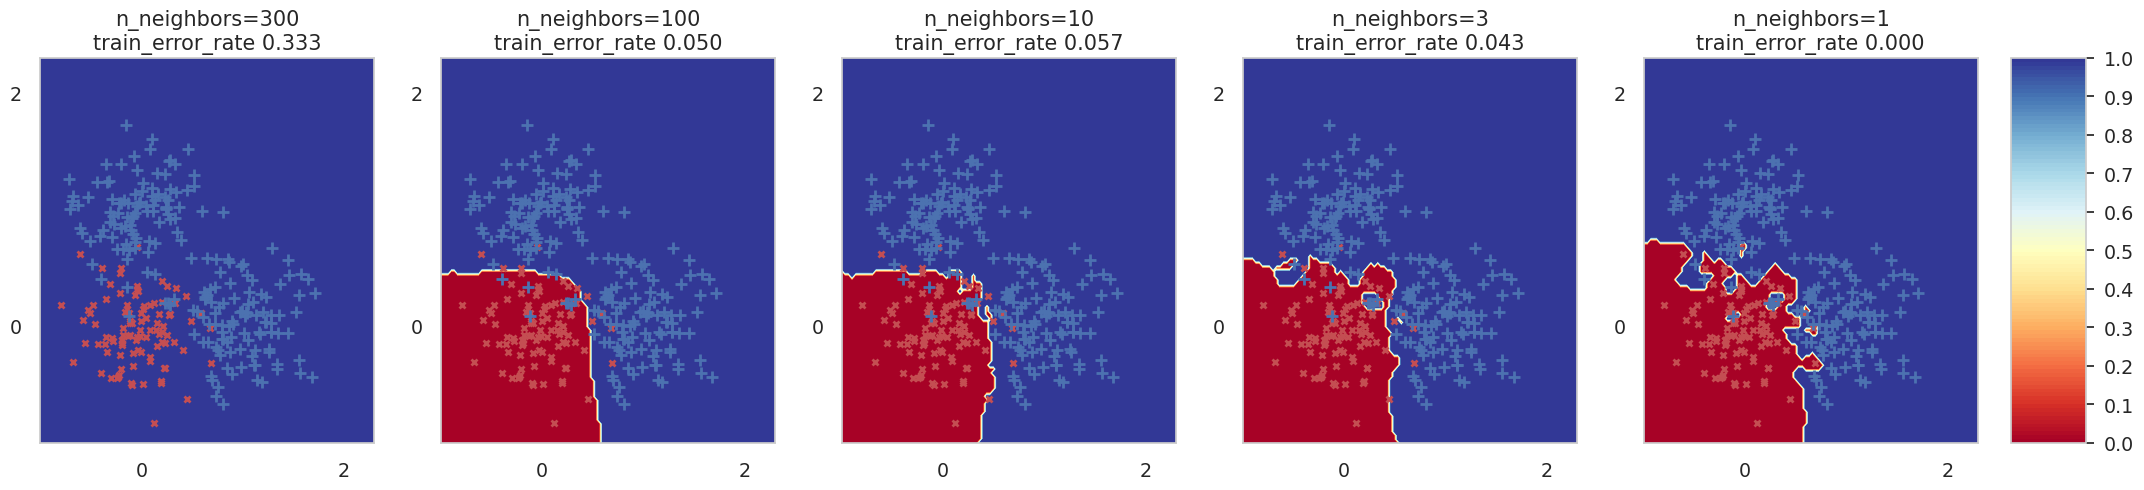

In [59]:
n_neighbors_grid = [y_N.size, 100, 10, 3,  1]
ncols = len(n_neighbors_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, n_neighbors in enumerate(n_neighbors_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='brute')
    clf.fit(x_N2, y_N)
    err_rate = np.mean(np.logical_xor(y_N, clf.predict(x_N2)))
    
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("n_neighbors=%d\ntrain_error_rate %.3f" % (n_neighbors, err_rate))

### Discussion 4a: Why does the rightmost KNN classifier get zero training error on the training set? Would we expect this on the validation set?

### Discussion 4b: How could you select the number of neighbors to use for this classifier?

# Part 6: Visualization of Logistic Regression predictions as we vary C

Remember, C controls the *strength* of the L2 penalty on weight parameters.

* Large C means almost no penalty.
* Small C means all weights are close to zero.

C =  0.0001 Learned weights + intercept
[0.00350085 0.00359415 0.69089817]
C =   0.01 Learned weights + intercept
[0.30417482 0.31712202 0.5030436 ]
C =      1 Learned weights + intercept
[ 3.69899517  4.09474074 -1.13523683]
C =  1e+02 Learned weights + intercept
[ 6.3519369   7.08534503 -2.22042321]
C =  1e+06 Learned weights + intercept
[ 6.44640774  7.19137113 -2.25808008]


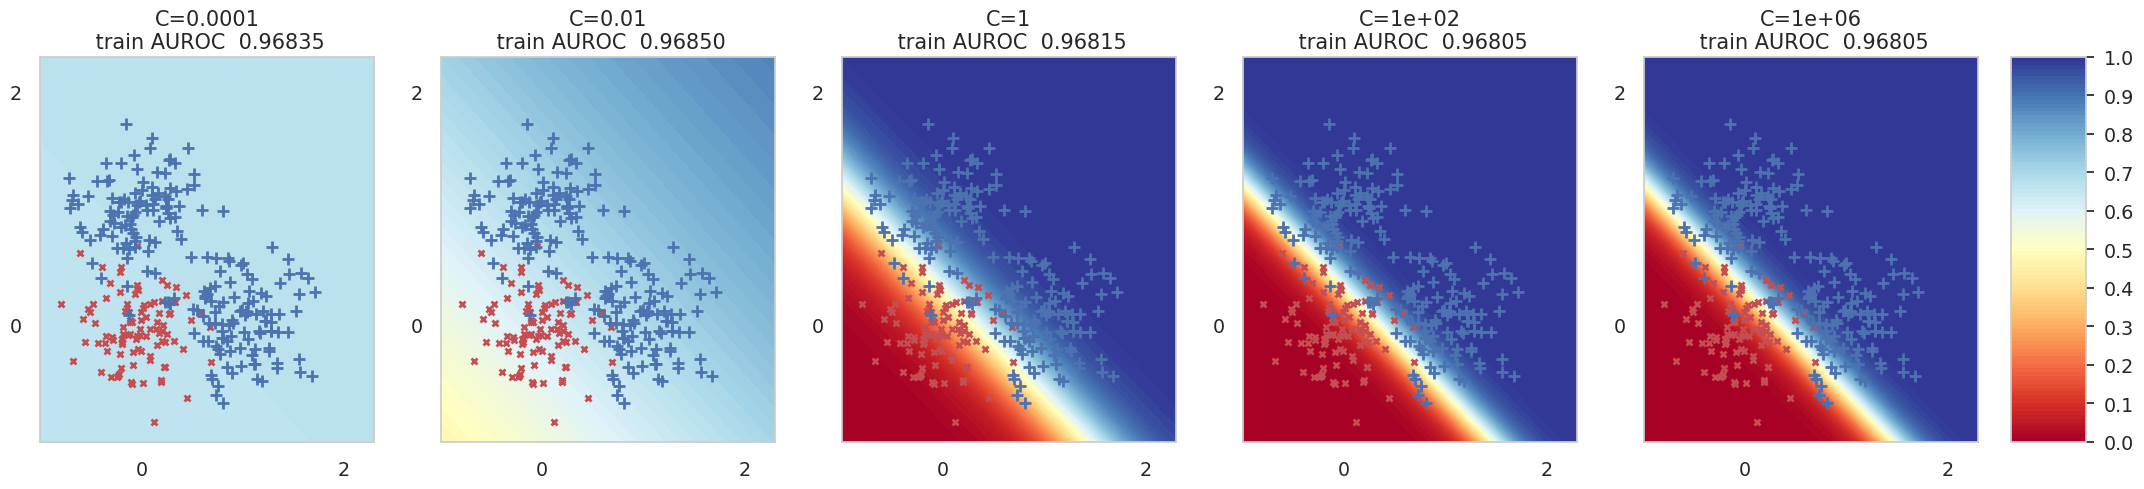

In [60]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 1000000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(x_N2, y_N)
    auroc = sklearn.metrics.roc_auc_score(y_N, clf.predict_proba(x_N2)[:,1])

    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("C=%.2g\n train AUROC % .5f" % (C, auroc))
    
    print("C = % 6.2g Learned weights + intercept" % C)
    print(np.hstack([clf.coef_.flatten(), np.atleast_1d(clf.intercept_)]))

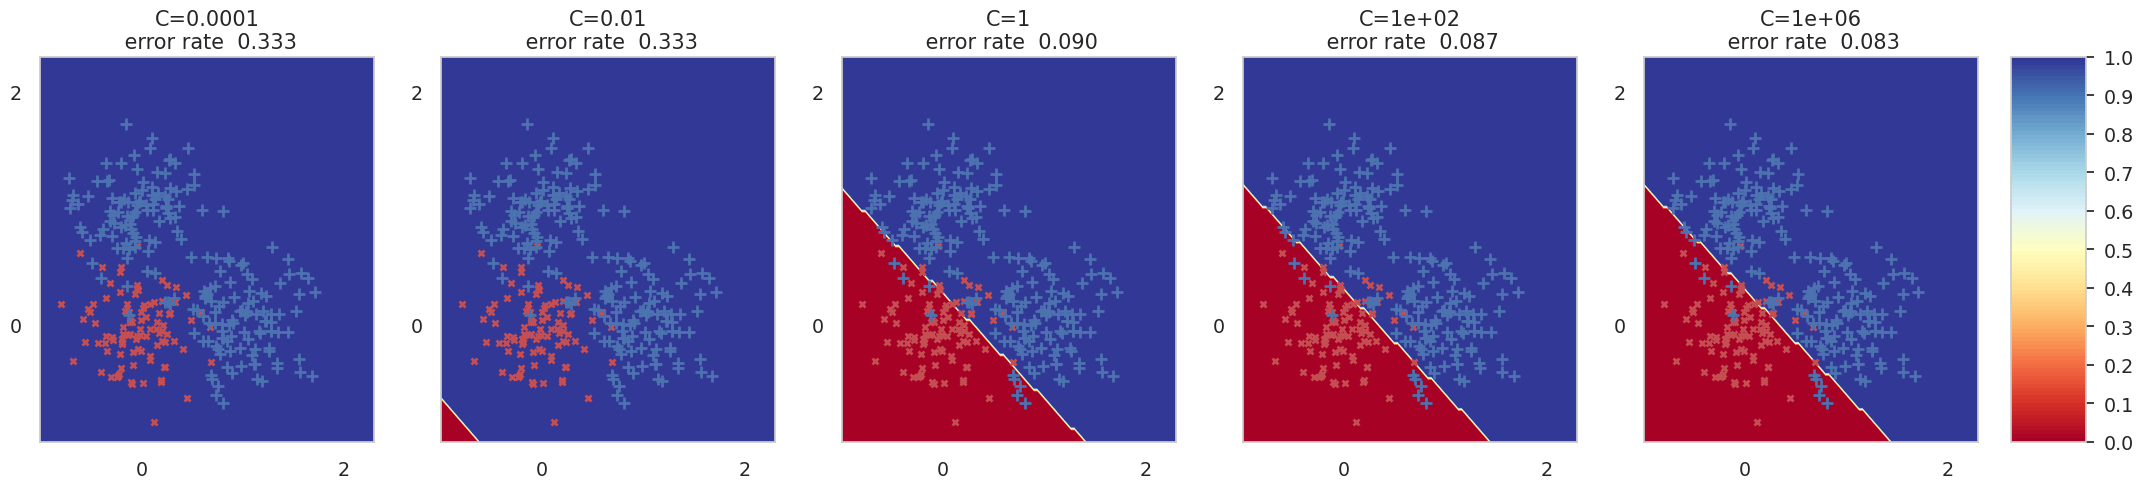

In [61]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 1000000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(x_N2, y_N)    
    err_rate = np.mean(np.logical_xor(y_N, clf.predict(x_N2)))
    
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("C=%.2g\n error rate % .3f" % (C, err_rate))

### Challenge Exercise 5a: Why does the decision boundary look like a line? Can you justify why it is linear with math?

Remember:

$$
p( y_n = 1 | x_n) = \sigma( w^T x_n + b )
$$

### Challenge Exercise 5b: Given the learned weights and intercept below, can you find the equation for the decision line?


In [62]:
clf.coef_

array([[6.44640774, 7.19137113]])

In [ ]:
clf.intercept_